
# Calibration de Heston via Reseau de Neurones + Couche de Pricing Carr-Madan (PyTorch)

Notebook didactique en francais.  
Objectif: predire les parametres du modele de Heston `(kappa, theta, sigma, rho, v0)` a partir de donnees marche `[r, T, S0, K, iv_BS]`, puis pricer un call avec une **couche de pricing differentiable** (Carr-Madan FFT) et apprendre par **descente de gradient** contre les **prix marche**.

## Contenu
1. Utilitaires Black-Scholes (prix et Vega) pour la perte ponderee.  
2. Couche de pricing Heston differenciable (Carr-Madan) en `torch`.  
3. reseau de neurones qui sort des parametres Heston avec contraintes de domaine.  
4. Fonctions de perte: MSE ponderee par **Vega** + penalite **Feller**.  
5. Jeu de donnees synthetique et boucle d'apprentissage.  
6. Diagnostics rapides.


In [33]:

# ==== Environnement ====
# pip install torch --upgrade

import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Precision numerique: float64 pour stabiliser l'FFT et l'autograd
torch.set_default_dtype(torch.float64)

# Appareil de calcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')


## 1) Utilitaires Black-Scholes

Ces fonctions servent a:
- Generer des **prix cibles** synthetiques (si besoin).
- Calculer la **Vega** pour **pondérer la MSE**.  
  L'idee: la variance des erreurs n'est pas homogene sur la surface; ponderer par `1/vega` stabilise le signal d'apprentissage.


In [34]:

# ---------------- Utilitaires Black-Scholes ----------------

def _ncdf(x: torch.Tensor) -> torch.Tensor:
    """Fonction de repartition de la loi normale standard (vectorisee)."""
    return 0.5*(1.0 + torch.erf(x / math.sqrt(2.0)))

def bs_call(S0: torch.Tensor, K: torch.Tensor, T: torch.Tensor,
            r: torch.Tensor, q: torch.Tensor, vol: torch.Tensor) -> torch.Tensor:
    """
    Prix du call European sous Black-Scholes (vectorise).
    Sert pour fabriquer des cibles synthetiques ou des bases de comparaison.
    """
    eps = torch.tensor(1e-12, dtype=S0.dtype, device=S0.device)
    S0, K, T, r, q, vol = map(lambda t: t.to(S0.dtype), (S0, K, T, r, q, vol))
    d1 = (torch.log(S0/K) + (r - q + 0.5*vol*vol)*T) / (vol*torch.sqrt(T+eps) + eps)
    d2 = d1 - vol*torch.sqrt(T+eps)
    return S0*torch.exp(-q*T)*_ncdf(d1) - K*torch.exp(-r*T)*_ncdf(d2)

def bs_vega(S0: torch.Tensor, K: torch.Tensor, T: torch.Tensor,
            r: torch.Tensor, q: torch.Tensor, vol: torch.Tensor) -> torch.Tensor:
    """
    Vega = dC/dvol sous Black-Scholes.
    Utilisee comme poids de la perte: w = 1/(Vega + eps).
    """
    eps = torch.tensor(1e-12, dtype=S0.dtype, device=S0.device)
    d1 = (torch.log(S0/K) + (r - q + 0.5*vol*vol)*T) / (vol*torch.sqrt(T+eps) + eps)
    phi = torch.exp(-0.5*d1*d1) / math.sqrt(2.0*math.pi)  # densite normale
    return S0*torch.exp(-q*T)*phi*torch.sqrt(T+eps)



## 2) Couche de pricing Heston (Carr-Madan FFT)

### Idees cles
- On utilise la **transformee de Fourier** du call amorti par `alpha` (Carr-Madan).  
- On evalue la **fonction caracteristique** (CF) de Heston avec le **Little Heston Trap** pour la stabilite numerique (`|g| < 1`).  
- On integre numeriquement via une **grille de frequences** et des **poids de Simpson**, puis **FFT**.  
- Interpolation **lineaire en log-strike** `k = ln K`.

La classe suivante est **differenciable** (PyTorch autograd) et vectorisee sur le batch.


In [35]:

# =========================
# Heston + Carr-Madan (torch)
# =========================
import math

class HestonPricingLayer(nn.Module):
    """
    Couche de pricing differentiable.
    Entrees: tenseurs batch (B,) pour S0,K,T,r,q et (kappa,theta,sigma,rho,v0).
    Sortie: prix de call (B,).
    """
    def __init__(self, N: int = 4096, eta: float = 0.25, alpha: float = 1.5):
        super().__init__()
        if N % 2 != 0:
            raise ValueError("N doit etre pair (poids de Simpson).")
        if alpha <= 0:
            raise ValueError("alpha doit etre > 0 (amortissement).")
        self.N = N
        self.eta = eta
        self.alpha = alpha

        # Grille des frequences v_n = n * eta et poids de Simpson
        n = torch.arange(N, dtype=torch.float64)
        v = eta * n
        w = torch.ones(N, dtype=torch.float64)
        w[1:N-1:2] = 4.0
        w[2:N-2:2] = 2.0
        w = w * (eta / 3.0)

        # Buffers (deplaces automatiquement sur le bon device)
        self.register_buffer("v", v)
        self.register_buffer("w", w)

        # Couplage FFT: pas en log-strike dk et demi-largeur b


        dk = (2.0 * math.pi) / (N * eta)  # -> float direct
        b  = 0.5 * N * dk
        self.dk = float(dk)               # pas de .item()
        self.b  = float(b)                # pas de .item()


    def _heston_cf(self, u: torch.Tensor, T: torch.Tensor, S0: torch.Tensor,
                   r: torch.Tensor, q: torch.Tensor,
                   kappa: torch.Tensor, theta: torch.Tensor,
                   sigma: torch.Tensor, rho: torch.Tensor, v0: torch.Tensor) -> torch.Tensor:
        """
        Fonction caracteristique de ln(S_T) sous Q (Little Heston Trap).
        u: (B,N) complexe ; T,S0,r,q,kappa,theta,sigma,rho,v0: broadcastables a (B,1).
        Retour: (B,N) complexe.
        """
        i = torch.complex(torch.tensor(0., dtype=torch.float64, device=u.device),
                          torch.tensor(1., dtype=torch.float64, device=u.device))
        x0 = torch.log(S0)

        a = kappa * theta
        b = kappa - rho * sigma * i * u
        d = torch.sqrt(b*b + (sigma**2) * (u*u + i*u))

        g = (b - d) / (b + d)
        # Stabilisation: force |g| < 1 numeriquement
        mask = (g.abs() >= 1.0)
        g = torch.where(mask, 1.0 / g, g)

        eDT = torch.exp(-d * T)
        one_minus_g = 1.0 - g
        one_minus_g_eDT = 1.0 - g * eDT

        eps = torch.tensor(1e-15, dtype=torch.float64, device=u.device)
        one_minus_g = torch.where(one_minus_g.abs() < eps, eps, one_minus_g)
        one_minus_g_eDT = torch.where(one_minus_g_eDT.abs() < eps, eps, one_minus_g_eDT)

        C = i*u*(r - q)*T + (a/(sigma**2)) * ((b - d)*T - 2.0*torch.log(one_minus_g_eDT/one_minus_g))
        D = ((b - d)/(sigma**2)) * ((1.0 - eDT)/one_minus_g_eDT)

        return torch.exp(C + D*v0 + i*u*x0)

    def forward(self, S0, K, T, r, q, kappa, theta, sigma, rho, v0) -> torch.Tensor:
        """Calcule le prix du call pour chaque ligne du batch."""
        device = S0.device
        dtype  = torch.float64

        v = self.v.to(device=device)
        w = self.w.to(device=device)
        N = self.N
        alpha = torch.as_tensor(self.alpha, dtype=dtype, device=device)

        # u = v - i*(alpha+1)
        i = torch.complex(torch.tensor(0., dtype=dtype, device=device),
                          torch.tensor(1., dtype=dtype, device=device))
        u_shift = v - (alpha + 1.0)*i  # (N,) complexe

        B = S0.shape[0]
        u = u_shift.unsqueeze(0).expand(B, N)  # (B,N)

        # Cast
        S0 = S0.to(dtype); K = K.to(dtype); T = T.to(dtype)
        r  = r.to(dtype);  q = q.to(dtype)
        kappa = kappa.to(dtype); theta = theta.to(dtype)
        sigma = sigma.to(dtype); rho = rho.to(dtype); v0 = v0.to(dtype)

        # CF decalee
        phi_shift = self._heston_cf(u, T[:,None], S0[:,None], r[:,None], q[:,None],
                                    kappa[:,None], theta[:,None], sigma[:,None],
                                    rho[:,None], v0[:,None])  # (B,N)

        # Denominateur (alpha+iv)(alpha+iv+1)
        denom = (alpha**2 + alpha - v**2 + (2*alpha + 1.0)*i*v)
        denom = torch.where(denom.abs() < 1e-30,
                            torch.complex(torch.tensor(1e-30, dtype=dtype, device=device),
                                          torch.tensor(0., dtype=dtype, device=device)),
                            denom)

        psi = torch.exp(-r[:,None]*T[:,None]) * phi_shift / denom

        # Couplage FFT
        dk = torch.as_tensor(self.dk, dtype=dtype, device=device)
        b  = torch.as_tensor(self.b,  dtype=dtype, device=device)
        x  = psi * torch.exp(1j * b * v) * w  # (B,N)

        F = torch.fft.fft(x, dim=-1).real  # (B,N)

        j = torch.arange(N, dtype=dtype, device=device)
        k_grid = -b + j * dk
        calls_grid = torch.exp(-alpha * k_grid)[None, :] / torch.pi * F  # (B,N)

        # Interpolation lineaire en log-strike
        k_target = torch.log(K).to(dtype)
        pos = (k_target + b) / dk
        idx1 = torch.clamp(pos.floor().long(), 0, N-2)
        idx2 = idx1 + 1

        k0 = k_grid[idx1]
        k1 = k_grid[idx2]
        c0 = calls_grid.gather(1, idx1.view(-1,1)).squeeze(1)
        c1 = calls_grid.gather(1, idx2.view(-1,1)).squeeze(1)
        w1 = (k_target - k0) / (k1 - k0 + 1e-16)
        price = c0 + (c1 - c0) * w1
        return price



## 3) Reseau de neurones pour parametres Heston

- Entree: `[r, T, S0, K, iv_BS]` pour chaque quote.  
- Sortie: `kappa, theta, sigma, rho, v0` contraints au bon domaine  
  (`softplus` pour positifs, `tanh` pour `rho`).  
- `q` est fixe a 0 ici pour simplifier (on peut l'apprendre si besoin).


In [36]:

class HestonCalibrator(nn.Module):
    """NN -> params Heston -> couche de pricing -> prix call."""
    def __init__(self, hidden: int = 128, N: int = 4096, eta: float = 0.25, alpha: float = 1.5):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(5, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 6)  # kappa, theta, sigma, rho, v0, q_shift (optionnel)
        )
        self.pricer = HestonPricingLayer(N=N, eta=eta, alpha=alpha)

        # Initialisation Xavier + biais de sortie plausibles
        for m in self.feature_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        with torch.no_grad():
            self.feature_net[-1].bias[:] = torch.tensor([ 0.7,   # kappa ~ 1+
                                                          -3.2,  # theta ~ 0.04
                                                          -0.7,  # sigma ~ 0.33
                                                           0.0,  # rho ~ 0
                                                          -3.2,  # v0   ~ 0.04
                                                           0.0], dtype=torch.float64)
    def forward(self, x: torch.Tensor, C_mkt: torch.Tensor = None,
                lambda_feller: float = 1e-3, lambda_ridge: float = 1e-6):
        """
        x: (B,5) = [r, T, S0, K, iv_BS]
        C_mkt: (B,) prix marche si fourni; sinon la fonction renvoie juste params + C_pred
        Renvoie un dict contenant params, C_pred et (si C_mkt) la loss totale.
        """
        dev = next(self.parameters()).device
        x = x.to(dtype=torch.float64, device=dev)

        r, T, S0, K, iv = x.unbind(dim=1)
        raw = self.feature_net(x)
        raw_kappa, raw_theta, raw_sigma, raw_rho, raw_v0, raw_qshift = raw.unbind(dim=1)

        # Contraintes de domaine
        kappa = F.softplus(raw_kappa) + 1e-6
        theta = F.softplus(raw_theta) + 1e-8
        sigma = F.softplus(raw_sigma) + 1e-8
        rho   = 0.999 * torch.tanh(raw_rho)
        v0    = F.softplus(raw_v0) + 1e-10
        q     = torch.zeros_like(r)  # dividende fixe ici

        # Pricing Heston
        C_pred = self.pricer(S0, K, T, r, q, kappa, theta, sigma, rho, v0)

        out = {"kappa": kappa, "theta": theta, "sigma": sigma, "rho": rho, "v0": v0, "C_pred": C_pred}
        if C_mkt is None:
            return out

        # Perte ponderee par Vega + penalites
        vega = bs_vega(S0, K, T, r, torch.zeros_like(r), iv)
        mse_w = weighted_mse(C_pred, C_mkt, vega)
        pen_feller = feller_penalty(kappa, theta, sigma).mean()
        pen_ridge  = (kappa.mean() + theta.mean() + sigma.mean() + v0.mean() + rho.pow(2).mean())

        loss = mse_w + lambda_feller*pen_feller + lambda_ridge*pen_ridge
        out.update({"loss": loss, "mse": mse_w, "pen_feller": pen_feller, "pen_ridge": pen_ridge})
        return out



## 4) Fonctions de perte et penalites

- **weighted_mse**: MSE ponderee par `1/(Vega+eps)`.  
- **feller_penalty**: penalise les violations de `2*kappa*theta >= sigma^2`.


In [37]:

def weighted_mse(C_pred: torch.Tensor, C_mkt: torch.Tensor, vega: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """MSE ponderee par 1/(Vega+eps) pour stabiliser l'apprentissage sur la surface."""
    w = 1.0 / (vega.abs() + eps)
    diff = C_pred - C_mkt
    return torch.mean((w * diff)**2)

def feller_penalty(kappa: torch.Tensor, theta: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    """Penalite de violation de la condition de Feller: 2*kappa*theta >= sigma^2."""
    return torch.relu(sigma*sigma - 2.0*kappa*theta)



## 5) Boucle d'apprentissage minimale


In [38]:

def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch_x: torch.Tensor, batch_Cmkt: torch.Tensor,
               lambda_feller: float = 1e-3, lambda_ridge: float = 1e-6):
    """
    Effectue une passe d'entrainement.
    Retourne des statistiques utiles (loss, mse, feller).
    """
    model.train()
    optimizer.zero_grad()

    out = model(batch_x, C_mkt=batch_Cmkt, lambda_feller=lambda_feller, lambda_ridge=lambda_ridge)
    out["loss"].backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()

    return {k: (v.detach() if torch.is_tensor(v) else v) for k, v in out.items()}



## 6) Donnees synthetiques et entrainement

Ici, on cree une surface synthetique en prennant les **prix Black-Scholes** a volatilite implicite 20% comme proxy de **prix marche**.  
En pratique, remplace par tes quotes.  


In [39]:
# ======================
# Chargement depuis ton CSV
# ======================
import pandas as pd
import os
print(os.getcwd())

csv_path = os.getcwd() + r"/heston_training_surface.csv"   # version "raw string"
df = pd.read_csv(csv_path)

# Vérifie les colonnes attendues
required_cols = {"r", "T", "S0", "K", "iv_bs", "C_mkt"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans le CSV : {missing}")

# Nettoyage basique
df = df.replace([float("inf"), -float("inf")], pd.NA).dropna(subset=list(required_cols))
if df.empty:
    raise ValueError("Le CSV ne contient aucune ligne valide après nettoyage.")

# Conversion en tenseurs torch
r  = torch.tensor(df["r"].values, dtype=torch.float64, device=device)
T  = torch.tensor(df["T"].values, dtype=torch.float64, device=device)
S0 = torch.tensor(df["S0"].values, dtype=torch.float64, device=device)
K  = torch.tensor(df["K"].values, dtype=torch.float64, device=device)
iv = torch.tensor(df["iv_bs"].values, dtype=torch.float64, device=device)
C_mkt = torch.tensor(df["C_mkt"].values, dtype=torch.float64, device=device)

# Empilement des features : (r, T, S0, K, iv_bs)
X = torch.stack([r, T, S0, K, iv], dim=1)

# ======================
# Initialisation modèle
# ======================
model = HestonCalibrator(hidden=128, N=2048, eta=0.20, alpha=1.5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ======================
# Entraînement
# ======================
EPOCHS = 15
for epoch in range(EPOCHS):
    stats = train_step(model, opt, X, C_mkt, lambda_feller=5e-4, lambda_ridge=1e-6)
    print(f"epoch {epoch+1:02d} | loss {stats['loss'].item():.6e} "
          f"| mse {stats['mse'].item():.6e} | feller {stats['pen_feller'].item():.3e}")




/home/salok1/MyQuantGuild/Highlight/39. Heston Stochastic Volatility Model and Fast Fourier Transforms/NN
epoch 01 | loss 4.780726e+107 | mse 4.780726e+107 | feller 0.000e+00
epoch 02 | loss 7.374131e+61 | mse 7.374131e+61 | feller 0.000e+00
epoch 03 | loss 2.751695e+36 | mse 2.751695e+36 | feller 0.000e+00
epoch 04 | loss 1.169089e+34 | mse 1.169089e+34 | feller 0.000e+00
epoch 05 | loss 1.015438e+16 | mse 1.015438e+16 | feller 0.000e+00
epoch 06 | loss nan | mse nan | feller nan
epoch 07 | loss nan | mse nan | feller nan
epoch 08 | loss nan | mse nan | feller nan
epoch 09 | loss nan | mse nan | feller nan
epoch 10 | loss nan | mse nan | feller nan
epoch 11 | loss nan | mse nan | feller nan
epoch 12 | loss nan | mse nan | feller nan
epoch 13 | loss nan | mse nan | feller nan
epoch 14 | loss nan | mse nan | feller nan
epoch 15 | loss nan | mse nan | feller nan



## 7) Diagnostics rapides
- Moyennes des parametres appris.  
- Erreur de pricing vs K/S0.  
- (Optionnel) verifie la parite put-call autour de l'ATM.


kappa nan
theta nan
sigma nan
rho nan
v0 nan


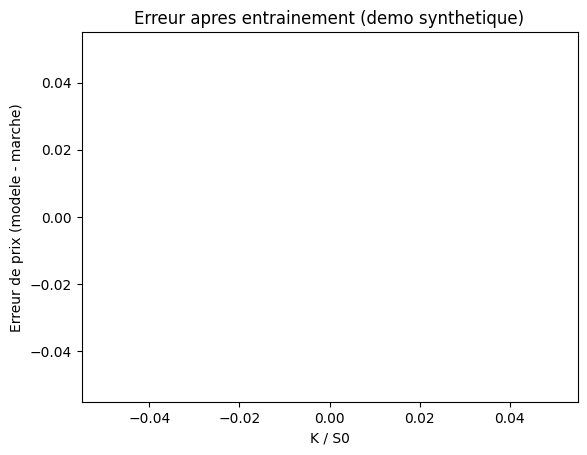

kappa nan
theta nan
sigma nan
rho nan
v0 nan


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:

with torch.no_grad():
    out = model(X)
    for k in ["kappa","theta","sigma","rho","v0"]:
        print(k, float(out[k].mean().item()))

    C_pred = out["C_pred"]
    err = (C_pred - C_mkt).detach().cpu()
    k_rel = (K/S0).detach().cpu()

plt.figure()
plt.plot(k_rel.numpy(), err.numpy(), marker='o', linestyle='None')
plt.xlabel('K / S0')
plt.ylabel('Erreur de prix (modele - marche)')
plt.title('Erreur apres entrainement (demo synthetique)')
plt.show()

def simulate_heston(S0, V0, T, r, kappa, theta, xi, rho, steps, n_paths):
    dt = T / steps
    S = np.zeros((steps + 1, n_paths))
    V = np.zeros((steps + 1, n_paths))
    S[0], V[0] = S0, V0

    for t in range(1, steps + 1):
        Z_S = np.random.standard_normal(n_paths)
        Z_V = rho * Z_S + np.sqrt(1 - rho**2) * np.random.standard_normal(n_paths)

        V_t = np.maximum(V[t-1] + kappa * (theta - V[t-1]) * dt + xi * np.sqrt(V[t-1] * dt) * Z_V, 0)
        S_t = S[t-1] * np.exp((r - 0.5 * V[t-1]) * dt + np.sqrt(V[t-1] * dt) * Z_S)

        S[t] = S_t
        V[t] = V_t

    return S, V

# Parameters
#S0, V0, T, r = 100, 0.04, 1, 0.05
kappa, theta, xi, rho = float(out["kappa"].mean().item()),  float(out["theta"].mean().item()), float(out["sigma"].mean().item()),  float(out["rho"].mean().item())
V0 =  float(out["v0"].mean().item())

for k in ["kappa","theta","sigma","rho","v0"]:
    print(k, float(out[k].mean().item()))

steps, n_paths = 252, 10000

# Simulate Heston paths
S_paths, V_paths = simulate_heston(S0, V0, T, r, kappa, theta, xi, rho, steps, n_paths)

# Plot example paths
plt.figure(figsize=(10, 5))
plt.plot(S_paths[:, :5])
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Simulated Heston Model Paths")
plt.show()



## 8) Utilisation avec donnees reelles

Attendu: un DataFrame avec colonnes `['r','T','S0','K','iv_bs','C_mkt']`. Exemple minimal:

```python
# import pandas as pd
# df = pd.read_csv('vos_quotes.csv')

r  = torch.tensor(df['r'    ].values, dtype=torch.float64, device=device)
T  = torch.tensor(df['T'    ].values, dtype=torch.float64, device=device)
S0 = torch.tensor(df['S0'   ].values, dtype=torch.float64, device=device)
K  = torch.tensor(df['K'    ].values, dtype=torch.float64, device=device)
iv = torch.tensor(df['iv_bs'].values, dtype=torch.float64, device=device)
C_mkt = torch.tensor(df['C_mkt'].values, dtype=torch.float64, device=device)

X = torch.stack([r,T,S0,K,iv], dim=1)

# Puis reutiliser train_step avec mini-batches si dataset volumineux.
```

### Conseils pratiques
- Commencer avec `N=1024..2048`, `eta ~ 0.15..0.30`, `alpha ~ 1.3..1.7`.
- Conserver `float64` pour la couche de pricing.
- Normaliser les features (log des prix, mise a l'echelle de T) si besoin.
- Sur oscilliations: reduire `lr`, augmenter `alpha` ou `N`, ou renforcer la penalite Feller.
